In [1]:
import os
import random
import shutil
from pathlib import Path

# Set random seed for reproducibility
random.seed(42)

# Source (original) directory and destination (split) directory
src_dir = Path("/kaggle/input/realwaste/realwaste-main/RealWaste")
dst_dir = Path("/kaggle/working/realwaste_split")

# Create train, val, and test directories with class subfolders
splits = ["train", "val", "test"]
for split in splits:
    for cls in os.listdir(src_dir):
        (dst_dir / split / cls).mkdir(parents=True, exist_ok=True)

# Split ratios
train_ratio, val_ratio = 0.7, 0.15  # 70% train, 15% val, 15% test

# Go through each class and copy images
for cls in os.listdir(src_dir):
    cls_dir = src_dir / cls
    images = list(cls_dir.glob("*.jpg")) + list(cls_dir.glob("*.png"))
    random.shuffle(images)

    n_total = len(images)
    n_train = int(train_ratio * n_total)
    n_val = int(val_ratio * n_total)

    for i, img_path in enumerate(images):
        if i < n_train:
            dest = dst_dir / "train" / cls / img_path.name
        elif i < n_train + n_val:
            dest = dst_dir / "val" / cls / img_path.name
        else:
            dest = dst_dir / "test" / cls / img_path.name
        shutil.copy(img_path, dest)

print("✅ Dataset successfully split into train/val/test folders at /kaggle/working/realwaste_split")


✅ Dataset successfully split into train/val/test folders at /kaggle/working/realwaste_split


In [2]:
for split in ["train", "val", "test"]:
    path = f"/kaggle/working/realwaste_split/{split}"
    classes = os.listdir(path)
    print(f"{split.upper()} contains {len(classes)} classes: {classes}")


TRAIN contains 9 classes: ['Paper', 'Cardboard', 'Plastic', 'Metal', 'Vegetation', 'Food Organics', 'Textile Trash', 'Glass', 'Miscellaneous Trash']
VAL contains 9 classes: ['Paper', 'Cardboard', 'Plastic', 'Metal', 'Vegetation', 'Food Organics', 'Textile Trash', 'Glass', 'Miscellaneous Trash']
TEST contains 9 classes: ['Paper', 'Cardboard', 'Plastic', 'Metal', 'Vegetation', 'Food Organics', 'Textile Trash', 'Glass', 'Miscellaneous Trash']


In [3]:
for split in ["train", "val", "test"]:
    total = 0
    for cls in os.listdir(f"/kaggle/working/realwaste_split/{split}"):
        n = len(os.listdir(f"/kaggle/working/realwaste_split/{split}/{cls}"))
        total += n
    print(f"{split}: {total} images")


train: 3323 images
val: 710 images
test: 719 images


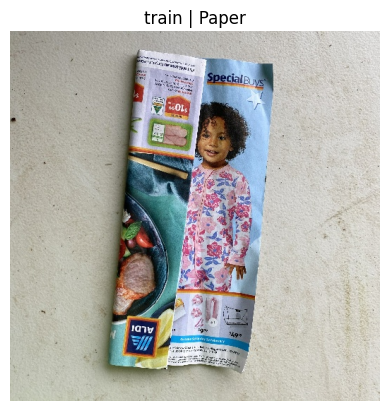

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
import random

split = "train"
cls = random.choice(os.listdir(f"/kaggle/working/realwaste_split/{split}"))
img_name = random.choice(os.listdir(f"/kaggle/working/realwaste_split/{split}/{cls}"))
img_path = f"/kaggle/working/realwaste_split/{split}/{cls}/{img_name}"

img = Image.open(img_path)
plt.imshow(img)
plt.title(f"{split} | {cls}")
plt.axis("off")
plt.show()


In [12]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Paths to your split dataset
train_dir = '/kaggle/working/realwaste_split/train'
val_dir = '/kaggle/working/realwaste_split/val'
test_dir = '/kaggle/working/realwaste_split/test'

# Check device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [6]:
# Transforms for train, val, and test sets
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [7]:
# Create datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=val_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Classes: {train_dataset.classes}")
print(f"Train images: {len(train_dataset)}, Val images: {len(val_dataset)}, Test images: {len(test_dataset)}")


Classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Train images: 3323, Val images: 710, Test images: 719


In [10]:
import torchvision

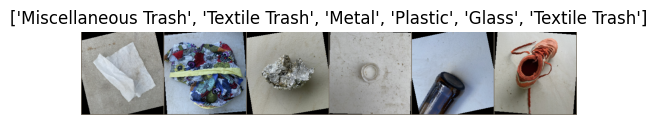

In [13]:
import numpy as np


# Show a few training images
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')

# Get one batch
inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs[:6])
imshow(out, title=[train_dataset.classes[x] for x in classes[:6]])


In [14]:
import torch.nn as nn
import torchvision.models as models

# Load pretrained ResNet50 model
resnet50 = models.resnet50(pretrained=True)

# Freeze earlier layers to keep pretrained weights
for param in resnet50.parameters():
    param.requires_grad = False

# Replace the final fully connected (FC) layer
num_features = resnet50.fc.in_features
num_classes = len(train_dataset.classes)  
resnet50.fc = nn.Linear(num_features, num_classes)

# Move model to GPU (if available)
resnet50 = resnet50.to(device)

print("Model modified successfully. Ready for training.")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 210MB/s]


Model modified successfully. Ready for training.


In [16]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.fc.parameters(), lr=0.001)


In [17]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=5):
    train_losses, val_losses = [], []
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 20)

        # TRAINING
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = 100 * correct / total

        # VALIDATION
        model.eval()
        val_running_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = 100 * val_correct / val_total

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")

    return model, train_losses, val_losses


In [18]:
num_epochs = 100  

resnet50, train_losses, val_losses = train_model(
    resnet50, criterion, optimizer, train_loader, val_loader, num_epochs=num_epochs
)



Epoch 1/100
--------------------
Train Loss: 1.4019 | Train Acc: 52.99%
Val Loss:   1.0424 | Val Acc:   64.08%

Epoch 2/100
--------------------
Train Loss: 0.9159 | Train Acc: 69.67%
Val Loss:   0.8505 | Val Acc:   70.99%

Epoch 3/100
--------------------
Train Loss: 0.7919 | Train Acc: 73.22%
Val Loss:   0.8263 | Val Acc:   71.55%

Epoch 4/100
--------------------
Train Loss: 0.7339 | Train Acc: 75.26%
Val Loss:   0.7985 | Val Acc:   71.55%

Epoch 5/100
--------------------
Train Loss: 0.6866 | Train Acc: 75.47%
Val Loss:   0.7328 | Val Acc:   74.23%

Epoch 6/100
--------------------
Train Loss: 0.6685 | Train Acc: 76.86%
Val Loss:   0.7317 | Val Acc:   73.10%

Epoch 7/100
--------------------
Train Loss: 0.6076 | Train Acc: 79.15%
Val Loss:   0.6981 | Val Acc:   75.21%

Epoch 8/100
--------------------
Train Loss: 0.5955 | Train Acc: 78.78%
Val Loss:   0.7347 | Val Acc:   74.37%

Epoch 9/100
--------------------
Train Loss: 0.6031 | Train Acc: 78.66%
Val Loss:   0.6823 | Val Acc:  

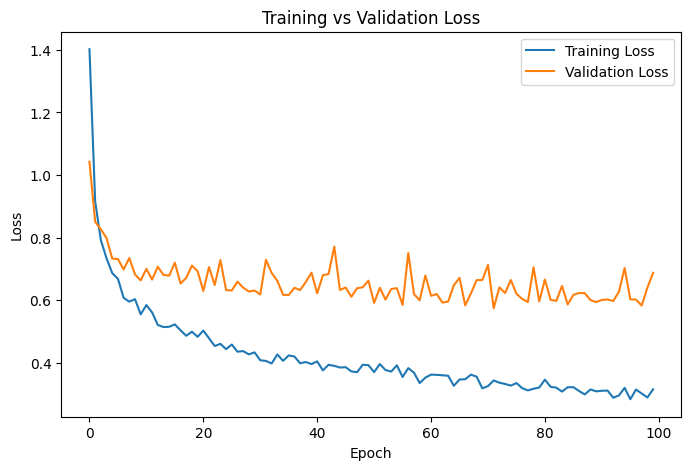

In [19]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Set model to evaluation mode
resnet50.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet50(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


In [21]:
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))


Classification Report:

                     precision    recall  f1-score   support

          Cardboard       0.81      0.81      0.81        70
      Food Organics       0.95      0.90      0.93        63
              Glass       0.88      0.71      0.79        63
              Metal       0.65      0.86      0.74       119
Miscellaneous Trash       0.78      0.67      0.72        75
              Paper       0.92      0.64      0.76        75
            Plastic       0.74      0.82      0.78       139
      Textile Trash       0.81      0.71      0.76        49
         Vegetation       0.93      0.97      0.95        66

           accuracy                           0.80       719
          macro avg       0.83      0.79      0.80       719
       weighted avg       0.81      0.80      0.80       719



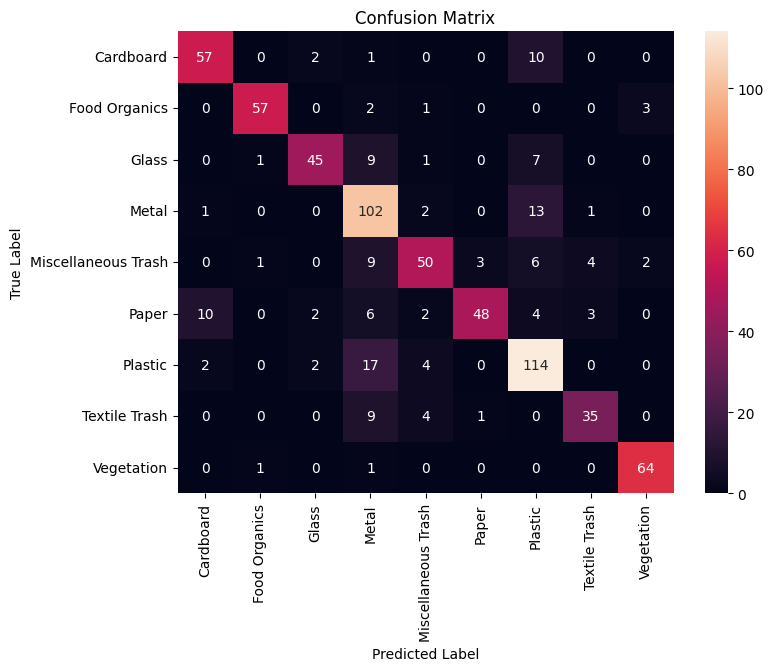

In [22]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [23]:
# Load pretrained DenseNet121
densenet = models.densenet121(pretrained=True)

# Freeze feature layers
for param in densenet.features.parameters():
    param.requires_grad = False

# Replace classifier layer
num_features = densenet.classifier.in_features
num_classes = len(train_dataset.classes)  # should be 9
densenet.classifier = nn.Linear(num_features, num_classes)

# Move to device (GPU if available)
densenet = densenet.to(device)

print("DenseNet121 modified successfully. Ready for training.")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 172MB/s]


DenseNet121 modified successfully. Ready for training.


In [24]:
criterion_dense = nn.CrossEntropyLoss()
optimizer_dense = optim.Adam(densenet.classifier.parameters(), lr=0.001)


In [25]:
num_epochs = 100  
densenet, train_losses_dense, val_losses_dense = train_model(
    densenet, criterion_dense, optimizer_dense, train_loader, val_loader, num_epochs=num_epochs
)



Epoch 1/100
--------------------
Train Loss: 1.5330 | Train Acc: 49.56%
Val Loss:   1.1311 | Val Acc:   63.52%

Epoch 2/100
--------------------
Train Loss: 0.9987 | Train Acc: 68.52%
Val Loss:   0.9266 | Val Acc:   68.03%

Epoch 3/100
--------------------
Train Loss: 0.8315 | Train Acc: 74.21%
Val Loss:   0.8324 | Val Acc:   72.39%

Epoch 4/100
--------------------
Train Loss: 0.7567 | Train Acc: 75.96%
Val Loss:   0.7799 | Val Acc:   73.80%

Epoch 5/100
--------------------
Train Loss: 0.6918 | Train Acc: 77.70%
Val Loss:   0.7455 | Val Acc:   73.10%

Epoch 6/100
--------------------
Train Loss: 0.6469 | Train Acc: 78.93%
Val Loss:   0.7494 | Val Acc:   73.66%

Epoch 7/100
--------------------
Train Loss: 0.6218 | Train Acc: 78.21%
Val Loss:   0.7267 | Val Acc:   73.66%

Epoch 8/100
--------------------
Train Loss: 0.5812 | Train Acc: 80.56%
Val Loss:   0.6755 | Val Acc:   76.90%

Epoch 9/100
--------------------
Train Loss: 0.5812 | Train Acc: 81.37%
Val Loss:   0.6734 | Val Acc:  

DenseNet121 Classification Report:

                     precision    recall  f1-score   support

          Cardboard       0.83      0.86      0.85        70
      Food Organics       0.88      0.94      0.91        63
              Glass       0.79      0.87      0.83        63
              Metal       0.71      0.92      0.80       119
Miscellaneous Trash       0.74      0.53      0.62        75
              Paper       0.87      0.71      0.78        75
            Plastic       0.82      0.68      0.75       139
      Textile Trash       0.77      0.84      0.80        49
         Vegetation       0.92      1.00      0.96        66

           accuracy                           0.80       719
          macro avg       0.81      0.82      0.81       719
       weighted avg       0.81      0.80      0.80       719



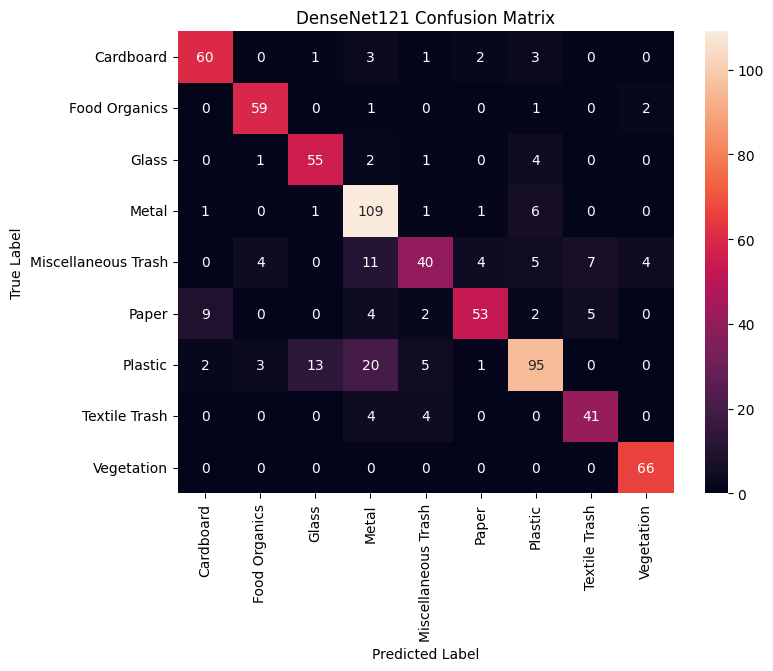

In [26]:
# Evaluation (reuse same approach as before)
densenet.eval()

all_preds_dense = []
all_labels_dense = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = densenet(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds_dense.extend(preds.cpu().numpy())
        all_labels_dense.extend(labels.cpu().numpy())

all_preds_dense = np.array(all_preds_dense)
all_labels_dense = np.array(all_labels_dense)

# Classification report
print("DenseNet121 Classification Report:\n")
print(classification_report(all_labels_dense, all_preds_dense, target_names=test_dataset.classes))

# Confusion matrix
cm_dense = confusion_matrix(all_labels_dense, all_preds_dense)
plt.figure(figsize=(8,6))
sns.heatmap(cm_dense, annot=True, fmt="d",
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("DenseNet121 Confusion Matrix")
plt.show()
